In [472]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as stats

In [387]:
from sklearn.model_selection import train_test_split
# import sklearn.model_selection.train_test_split as train_test_split

import statsmodels.formula.api as smf
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression
# sklearn - scikit learn

In [388]:
cars= pd.read_csv("C:\Alabs\Datasets\Car_sales - 1656244153716.csv", sep= "," )

In [389]:
cars.head()

,Manufacturer,Model,Sales_in_thousands,four_year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150
1,Acura,TL,39.384,19.875,Passenger,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778
2,Acura,CL,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,1/4/2012,NaN
3,Acura,RL,8.588,29.725,Passenger,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,3/10/2011,91.389779
4,Audi,A4,20.397,22.255,Passenger,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10/8/2011,62.777639


In [390]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Manufacturer            157 non-null    object 
 1   Model                   157 non-null    object 
 2   Sales_in_thousands      157 non-null    float64
 3   four_year_resale_value  121 non-null    float64
 4   Vehicle_type            157 non-null    object 
 5   Price_in_thousands      155 non-null    float64
 6   Engine_size             156 non-null    float64
 7   Horsepower              156 non-null    float64
 8   Wheelbase               156 non-null    float64
 9   Width                   156 non-null    float64
 10  Length                  156 non-null    float64
 11  Curb_weight             155 non-null    float64
 12  Fuel_capacity           156 non-null    float64
 13  Fuel_efficiency         154 non-null    float64
 14  Latest_Launch           157 non-null    ob

In [391]:
cars.nunique()

Manufacturer               30
Model                     156
Sales_in_thousands        157
four_year_resale_value    117
Vehicle_type                2
Price_in_thousands        152
Engine_size                31
Horsepower                 66
Wheelbase                  88
Width                      78
Length                    127
Curb_weight               147
Fuel_capacity              55
Fuel_efficiency            20
Latest_Launch             130
Power_perf_factor         154
dtype: int64

In [392]:
cars_cat_var = cars.select_dtypes('object').columns
cars_con_var = cars.select_dtypes('float64').columns

In [393]:
cars_cat_var = cars_cat_var.drop(labels= 'Latest_Launch')

In [394]:
cars_cat_var

Index(['Manufacturer', 'Model', 'Vehicle_type'], dtype='object')

In [395]:
def fn_desc( x ):
    # missing values calculation
    ntot = x.shape[0]
    n = x.count()
    n_miss = ntot - n
    n_miss_perc = n_miss/ntot
    
    # get the lc and uc using IQR
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    IQR = q3 - q1
    lc_iqr = q1 - 1.5 * IQR
    uc_iqr = q3 + 1.5 * IQR
    
    # return the descriptives
    
    return pd.Series([x.dtype, x.nunique(),
                       ntot, n, n_miss, n_miss_perc,
                      IQR, lc_iqr, uc_iqr,
                      x.sum(), x.mean(), x.var(), x.std(),
                      x.min(), 
                      x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), 
                      x.quantile(0.25), x.quantile(0.5), x.quantile(0.75), 
                      x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), 
                      x.max() ],
                     index = ['dtype', 'cardinality',
                               'ntot', 'n', 'n_miss', 'n_miss_perc',
                              'IQR', 'lc_iqr', 'uc_iqr',
                              'sum', 'mean', 'var', 'std',
                              'min', 
                              'p1', 'p5', 'p10', 
                              'p25', 'p50', 'p75', 
                              'p90', 'p95', 'p99',
                              'max' ])

In [396]:
cars.loc[:, cars_con_var].apply(fn_desc)

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
cardinality,157,117,152,31,66,88,78,127,147,55,20,154
ntot,157,157,157,157,157,157,157,157,157,157,157,157
n,157,121,155,156,156,156,156,156,155,156,154,155
n_miss,0,36,2,1,1,1,1,1,2,1,3,2
n_miss_perc,0.0,0.229299,0.012739,0.006369,0.006369,0.006369,0.006369,0.006369,0.012739,0.006369,0.019108,0.012739
IQR,53.842,8.615,13.93,1.275,65.5,9.2,5.025,18.55,0.8285,3.775,5.0,29.007171
lc_iqr,-66.649,-1.6625,-2.8775,0.3875,51.25,89.2,60.8625,149.75,1.72825,10.1375,13.5,16.896951
uc_iqr,148.719,32.7975,52.8425,5.4875,313.25,126.0,80.9625,223.95,5.04225,25.2375,33.5,132.925634
sum,8320.698,2186.83,4245.567,477.5,29008.0,16768.0,11099.4,29225.6,523.594,2800.5,3672.0,11941.756636


In [397]:
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [398]:
cars.loc[:, cars_cat_var].apply(categorical_var_summary)

,Manufacturer,Model,Vehicle_type
N,157,157,157
NMISS,0,0,0
MODE,Dodge,Neon,Passenger
FREQ,11,2,116
PERCENT,7.01,1.27,73.89


In [399]:
#Outlier treatment
cars.loc[:, cars_con_var].apply( lambda x: x.clip (lower= x.quantile(0.01),upper= x.quantile(0.99)) )

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
0,16.919,16.360,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,58.280150
1,39.384,19.875,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,91.370778
2,14.114,18.225,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,NaN
3,8.588,29.725,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,91.389779
4,20.397,22.255,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,62.777639
...,...,...,...,...,...,...,...,...,...,...,...,...
152,3.545,NaN,24.40,1.9,160.0,100.5,67.6,176.6,3.042,15.8,25.0,66.498812
153,15.245,NaN,27.50,2.4,168.0,104.9,69.3,185.9,3.208,17.9,25.0,70.654495
154,17.531,NaN,28.80,2.4,168.0,104.9,69.3,186.2,3.259,17.9,25.0,71.155978
155,3.493,NaN,45.50,2.3,236.0,104.9,71.5,185.7,3.601,18.5,23.0,101.623357


In [400]:
cars_cont = cars.loc[:, cars_con_var].apply( lambda x: x.clip (lower= x.quantile(0.01),upper= x.quantile(0.99)) )

In [401]:
cars_cont =  cars_cont.apply( lambda x: x.fillna (  x.mean() ) )

In [402]:
cars_cont.loc[:, cars_con_var].apply(fn_desc)

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
cardinality,155,116,151,30,65,88,77,126,146,55,20,153
ntot,157,157,157,157,157,157,157,157,157,157,157,157
n,157,157,157,157,157,157,157,157,157,157,157,157
n_miss,0,0,0,0,0,0,0,0,0,0,0,0
n_miss_perc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IQR,53.842,5.595,13.785,1.2,65.0,9.2,5.0,18.5,0.803,3.7,5.0,28.674488
lc_iqr,-66.649,4.1525,-2.5325,0.5,52.5,89.2,60.9,149.85,1.7705,10.25,13.5,17.715715
uc_iqr,148.719,26.5325,52.6075,5.3,312.5,126.0,80.9,223.85,4.9825,25.05,33.5,132.413666
sum,8025.5292,2829.141298,4290.61297,478.860064,29095.622436,16867.536538,11173.619551,29411.272949,530.528485,2817.848077,3731.298701,12065.384534


In [403]:
cars_cat = cars.loc[:, 'Vehicle_type']
cars_cat

0      Passenger
1      Passenger
2      Passenger
3      Passenger
4      Passenger
         ...    
152    Passenger
153    Passenger
154    Passenger
155    Passenger
156    Passenger
Name: Vehicle_type, Length: 157, dtype: object

In [404]:
cars_cat = pd.get_dummies( cars_cat, drop_first= True, dtype= 'int' )
cars_cat

,Passenger
0,1
1,1
2,1
3,1
4,1
...,...
152,1
153,1
154,1
155,1


In [405]:
# combining Categorical and Continuous vars DF
cars_new = pd.concat([cars_cat, cars_cont, ], axis = 1)
cars_new

,Passenger,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
0,1,16.919,16.360000,21.500000,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,58.280150
1,1,39.384,19.875000,28.400000,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,91.370778
2,1,14.114,18.225000,27.328745,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,76.849583
3,1,8.588,29.725000,42.000000,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,91.389779
4,1,20.397,22.255000,23.990000,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,62.777639
...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,1,3.545,18.020008,24.400000,1.9,160.0,100.5,67.6,176.6,3.042,15.8,25.0,66.498812
153,1,15.245,18.020008,27.500000,2.4,168.0,104.9,69.3,185.9,3.208,17.9,25.0,70.654495
154,1,17.531,18.020008,28.800000,2.4,168.0,104.9,69.3,186.2,3.259,17.9,25.0,71.155978
155,1,3.493,18.020008,45.500000,2.3,236.0,104.9,71.5,185.7,3.601,18.5,23.0,101.623357


<Axes: ylabel='Density'>

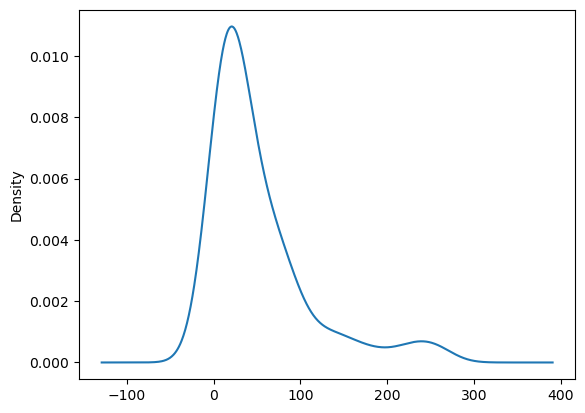

In [406]:
cars_new.loc[:, 'Sales_in_thousands'].plot(kind= 'kde')

In [407]:
cars_new.loc[:, 'Sales_in_thousands'].skew()

1.9924932920508793

In [408]:
cars_new.loc[:, 'log_sales'] = np.log(cars_new.loc[:, 'Sales_in_thousands'])

<Axes: ylabel='Density'>

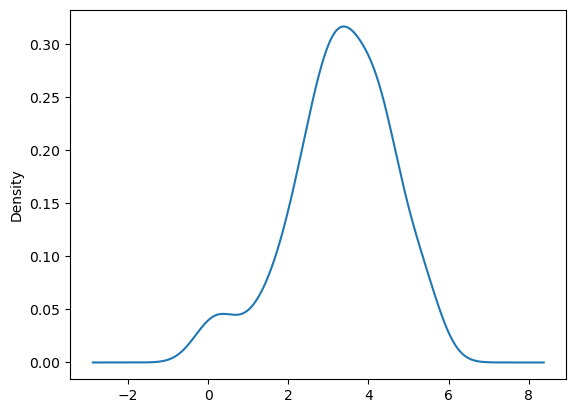

In [409]:
cars_new.loc[:, 'log_sales'].plot(kind= 'kde')

In [410]:
cars_new.loc[:, 'log_sales'].skew()

-0.5925861100519006

In [411]:
cars_new.columns

Index(['Passenger', 'Sales_in_thousands', 'four_year_resale_value',
       'Price_in_thousands', 'Engine_size', 'Horsepower', 'Wheelbase', 'Width',
       'Length', 'Curb_weight', 'Fuel_capacity', 'Fuel_efficiency',
       'Power_perf_factor', 'log_sales'],
      dtype='object')

In [412]:
x_var = cars_new.columns.difference( ['log_sales', 'Sales_in_thousands' ] )
y_var = 'log_sales'

In [413]:
cars_new.corr()

,Passenger,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor,log_sales
Passenger,1.000000,-0.230252,0.076638,0.042006,-0.279272,-0.011910,-0.383084,-0.241472,-0.129701,-0.519405,-0.594758,0.598061,-0.003672,-0.272796
Sales_in_thousands,-0.230252,1.000000,-0.307538,-0.361572,-0.014342,-0.259311,0.278280,0.093054,0.200997,-0.035282,0.044446,0.036677,-0.285253,0.799513
four_year_resale_value,0.076638,-0.307538,1.000000,0.832320,0.440258,0.679605,-0.037624,0.158211,0.025517,0.304378,0.284274,-0.364342,0.730596,-0.479350
Price_in_thousands,0.042006,-0.361572,0.832320,1.000000,0.618230,0.849851,0.118080,0.328107,0.158161,0.527230,0.430942,-0.505995,0.906767,-0.578170
Engine_size,-0.279272,-0.014342,0.440258,0.618230,1.000000,0.815010,0.518423,0.702618,0.576386,0.793937,0.698341,-0.757170,0.796880,-0.120983
Horsepower,-0.011910,-0.259311,0.679605,0.849851,0.815010,1.000000,0.325247,0.538115,0.420472,0.637823,0.526554,-0.611060,0.990906,-0.400528
Wheelbase,-0.383084,0.278280,-0.037624,0.118080,0.518423,0.325247,1.000000,0.681402,0.837566,0.657133,0.659706,-0.499341,0.288757,0.270203
Width,-0.241472,0.093054,0.158211,0.328107,0.702618,0.538115,0.681402,1.000000,0.700153,0.710589,0.648557,-0.585266,0.506650,0.038309
Length,-0.129701,0.200997,0.025517,0.158161,0.576386,0.420472,0.837566,0.700153,1.000000,0.622789,0.561884,-0.419443,0.370951,0.207226
Curb_weight,-0.519405,-0.035282,0.304378,0.527230,0.793937,0.637823,0.657133,0.710589,0.622789,1.000000,0.868131,-0.829699,0.630137,-0.051904


### significance: F_Regression

In [414]:
# feature selection based on importance
from sklearn.feature_selection import f_regression

In [415]:
f_regression(X = cars_new.loc[:, x_var], y = cars_new.loc[:, y_var])

(array([4.18695089e-01, 2.30243438e+00, 5.92603833e-02, 2.87754780e+00,
        2.96167448e+01, 6.95475283e+00, 1.24621571e+01, 3.87361057e+01,
        7.78307105e+01, 1.22078174e+01, 2.27812424e-01, 4.62401794e+01]),
 array([5.18546002e-01, 1.31208332e-01, 8.07990658e-01, 9.18301392e-02,
        2.01694032e-07, 9.21120686e-03, 5.47016937e-04, 4.33572718e-09,
        2.20677510e-15, 6.20547438e-04, 6.33822964e-01, 2.13506077e-10]))

In [416]:
f_val, p_val = f_regression(X = cars_new.loc[:, x_var], y = cars_new.loc[:, y_var])

In [417]:
f_reg = pd.DataFrame(data = [x_var, f_val, p_val] ).T
f_reg.columns = ['Features', 'F_value', 'P_value']

In [418]:
f_reg

,Features,F_value,P_value
0,Curb_weight,0.418695,0.518546
1,Engine_size,2.302434,0.131208
2,Fuel_capacity,0.05926,0.807991
3,Fuel_efficiency,2.877548,0.09183
4,Horsepower,29.616745,0.0
5,Length,6.954753,0.009211
6,Passenger,12.462157,0.000547
7,Power_perf_factor,38.736106,0.0
8,Price_in_thousands,77.83071,0.0
9,Wheelbase,12.207817,0.000621


In [419]:
f_reg.loc[f_reg.P_value < 0.10]

,Features,F_value,P_value
3,Fuel_efficiency,2.877548,0.09183
4,Horsepower,29.616745,0.0
5,Length,6.954753,0.009211
6,Passenger,12.462157,0.000547
7,Power_perf_factor,38.736106,0.0
8,Price_in_thousands,77.83071,0.0
9,Wheelbase,12.207817,0.000621
11,four_year_resale_value,46.240179,0.0


In [420]:
f_reg.loc[f_reg.P_value < 0.10, 'Features']

3            Fuel_efficiency
4                 Horsepower
5                     Length
6                  Passenger
7          Power_perf_factor
8         Price_in_thousands
9                  Wheelbase
11    four_year_resale_value
Name: Features, dtype: object

In [421]:
features = list(f_reg.loc[f_reg.P_value < 0.10, 'Features'])

In [422]:
'log_sales~'+ '+'.join(features)

'log_sales~Fuel_efficiency+Horsepower+Length+Passenger+Power_perf_factor+Price_in_thousands+Wheelbase+four_year_resale_value'

In [423]:
formula_m1 = 'log_sales~'+ '+'.join(features)
formula_m1

'log_sales~Fuel_efficiency+Horsepower+Length+Passenger+Power_perf_factor+Price_in_thousands+Wheelbase+four_year_resale_value'

In [424]:
train, test = train_test_split( cars_new, test_size= 0.3, random_state = 1 )

In [425]:
lm1 = smf.ols( formula_m1,train ).fit( )
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     10.46
Date:                Sat, 06 Jul 2024   Prob (F-statistic):           1.50e-10
Time:                        10:49:23   Log-Likelihood:                -145.10
No. Observations:                 109   AIC:                             308.2
Df Residuals:                     100   BIC:                             332.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2

## Multicollinearity : VIF

In [442]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

y, X = dmatrices(formula_m2, data=cars_new, return_type="dataframe")


vif_factor = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]


In [443]:
vif_factor

[579.4523372775424,
 5.237298023406948,
 4.069285450681525,
 1.528492648841292,
 3.763389848827614,
 2.331198775022431]

In [444]:
vif = pd.DataFrame()

In [445]:
vif['features'] =  X.columns
vif

,features
0,Intercept
1,Horsepower
2,Price_in_thousands
3,Wheelbase
4,Fuel_efficiency
5,Passenger


In [446]:
[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

[579.4523372775424,
 5.237298023406948,
 4.069285450681525,
 1.528492648841292,
 3.763389848827614,
 2.331198775022431]

In [447]:
vif['VIF_Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [448]:
vif

,features,VIF_Factor
0,Intercept,579.452337
1,Horsepower,5.237298
2,Price_in_thousands,4.069285
3,Wheelbase,1.528493
4,Fuel_efficiency,3.763390
5,Passenger,2.331199


In [449]:
vif = vif.round(1).sort_values(by = 'VIF_Factor', ascending= False)
vif[vif.VIF_Factor < 6]

,features,VIF_Factor
1,Horsepower,5.2
2,Price_in_thousands,4.1
4,Fuel_efficiency,3.8
5,Passenger,2.3
3,Wheelbase,1.5


In [450]:
formula_m2 = 'log_sales~Fuel_efficiency+Horsepower+Passenger+Price_in_thousands+Wheelbase'

In [451]:
features = list(vif.loc[vif.VIF_Factor < 6, 'features'])

In [452]:
'log_sales ~' + '+'.join(features)

'log_sales ~Horsepower+Price_in_thousands+Fuel_efficiency+Passenger+Wheelbase'

In [453]:
formula_m2 = 'log_sales ~Horsepower+Price_in_thousands+Wheelbase+Fuel_efficiency+Passenger'

### removal of multicolinear variables (one at a time and running codes starting from VIF steps again to check changes in VIF)

In [441]:
lm2 = smf.ols( formula_m2, train).fit()
print( lm2.summary() )

                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     16.36
Date:                Sat, 06 Jul 2024   Prob (F-statistic):           7.46e-12
Time:                        10:50:25   Log-Likelihood:                -146.37
No. Observations:                 109   AIC:                             304.7
Df Residuals:                     103   BIC:                             320.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -2.5077      2

In [458]:
y_tr_pred = lm2.predict(train)
y_test_pred= lm2.predict(test)

## Inverse log for the predicted y train and predicted y test, to undo log transformation done earlier (rescaling to original units)

In [460]:
y_tr_pred = np.exp(lm2.predict(train))
y_tr_pred

135    41.923202
77     12.730963
18     16.225397
48     39.462766
4      22.680235
         ...    
133    47.718684
137    34.980067
72     11.228709
140    70.287357
37     32.093368
Length: 109, dtype: float64

In [461]:
y_test_pred = np.exp(lm2.predict(test))
y_test_pred

117     12.647779
75      21.629124
51      36.659192
31      42.439239
35      53.939213
40     190.588854
14      20.212164
109     32.885723
53      80.165089
147     32.262427
151     19.134560
78      26.985249
92      18.315727
90      37.980310
89      35.762602
5       14.554230
123     83.084105
16      14.394888
19      39.266555
29      22.517090
56     124.728259
150     24.112584
143     42.047705
99       1.773841
93       8.870717
69      30.092982
94       4.177774
42     100.474167
122     38.114226
44      51.039335
105     23.471589
138     31.920693
66      12.728546
33      43.368996
141     74.001436
59      44.658248
127     12.756211
131     48.239750
149     21.891616
125      1.091281
58      43.719837
28      26.038048
124      5.239295
111     20.747351
54      32.184214
17      16.322144
73       7.986073
104     43.360243
dtype: float64

In [464]:
# MAPE = Mean Absolute Percentage Error
mape_train = mean_absolute_percentage_error(train.Sales_in_thousands, y_tr_pred)
mape_test = mean_absolute_percentage_error(test.Sales_in_thousands, y_test_pred)
print('MAPE:', 'train:',  mape_train, 'test:', mape_test)

MAPE: train: 1.1453574352935716 test: 0.8510969749592411


In [465]:
# Mean Squared Error
mse_train = mean_squared_error(train.Sales_in_thousands, y_tr_pred)
mse_test = mean_squared_error(test.Sales_in_thousands, y_test_pred)
print('MSE:', mse_train, mse_test)
print('RMSE:', np.sqrt(mse_train), np.sqrt(mse_test))

MSE: 2684.181322357338 2497.457676910126
RMSE: 51.809085326391724 49.974570302406065


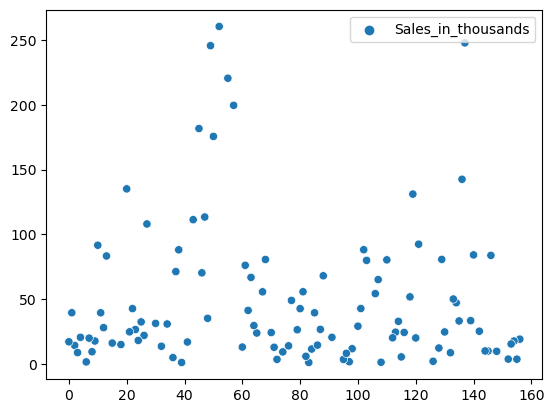

In [475]:
sns.scatterplot(data=[train.Sales_in_thousands, y_tr_pred ])
plt.show( )

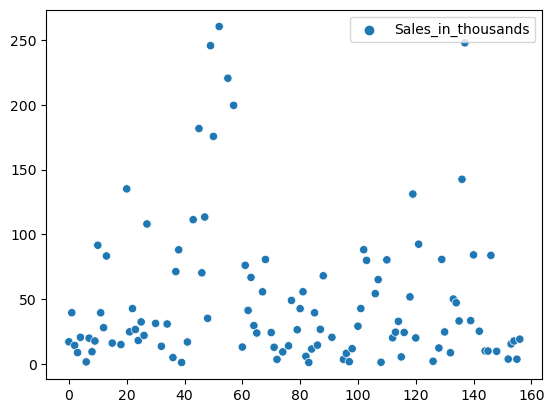

In [476]:
sns.scatterplot(data=[train.Sales_in_thousands, y_test_pred ])
plt.show( )

Since the errors are more in both train and test data, this is an underfit model

Model Validation

In [478]:
lm2.resid

135   -0.238484
77     1.345965
18    -0.092965
48    -0.118069
4     -0.106106
         ...   
133    0.046480
137    1.958626
72    -1.214301
140    0.179260
37     0.796647
Length: 109, dtype: float64